<a href="https://colab.research.google.com/github/Eswarchinthakayala-webdesign/SPIC4A61/blob/main/Genetic%20vs%20RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!git clone https://github.com/microsoft/CodeXGLUE.git


Cloning into 'CodeXGLUE'...
remote: Enumerating objects: 3373, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 3373 (delta 218), reused 211 (delta 211), pack-reused 3124 (from 3)
Receiving objects: 100% (3373/3373), 213.15 MiB | 13.95 MiB/s, done.
Resolving deltas: 100% (1740/1740), done.
Updating files: 100% (400/400), done.


In [3]:
import pandas as pd


train_file = "/content/CodeXGLUE/Code-Code/Clone-detection-BigCloneBench/dataset/train.txt"
valid_file = "/content/CodeXGLUE/Code-Code/Clone-detection-BigCloneBench/dataset/valid.txt"
test_file = "/content/CodeXGLUE/Code-Code/Clone-detection-BigCloneBench/dataset/test.txt"


with open(train_file, 'r', encoding='utf-8') as f:
    train_data = f.readlines()

with open(valid_file, 'r', encoding='utf-8') as f:
    valid_data = f.readlines()

with open(test_file, 'r', encoding='utf-8') as f:
    test_data = f.readlines()

print("Loaded Dataset Samples:")
print(train_data[:5])


Loaded Dataset Samples:
['13988825\t8660836\t0\n', '80378\t18548122\t1\n', '21354223\t7421563\t1\n', '15826299\t19728871\t0\n', '9938081\t11517213\t0\n']


In [4]:
import re
import numpy as np

def preprocess_data(data):
    """Cleans and tokenizes input code data."""
    cleaned_data = []
    for line in data:
        line = line.strip()
        line = re.sub(r'[^a-zA-Z0-9\s]', '', line)
        cleaned_data.append(line.lower())
    return cleaned_data


train_data_clean = preprocess_data(train_data)
valid_data_clean = preprocess_data(valid_data)
test_data_clean = preprocess_data(test_data)

print("Sample Preprocessed Data:", train_data_clean[:5])


Sample Preprocessed Data: ['13988825\t8660836\t0', '80378\t18548122\t1', '21354223\t7421563\t1', '15826299\t19728871\t0', '9938081\t11517213\t0']


In [5]:
def extract_features(data):
    """Extracts features from the cleaned dataset."""
    features = []
    for code in data:
        tokens = code.split()
        num_tokens = len(tokens)
        num_lines = code.count("\n") + 1
        max_line_length = max([len(line) for line in code.split("\n")]) if code else 0
        char_dist = [code.count(char) for char in "abcdefghijklmnopqrstuvwxyz0123456789"]
        features.append([num_tokens, num_lines, max_line_length] + char_dist)
    return np.array(features)


train_features = extract_features(train_data_clean)
valid_features = extract_features(valid_data_clean)
test_features = extract_features(test_data_clean)

print("Feature Shape:", train_features.shape)


Feature Shape: (901028, 39)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class RLAgent(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RLAgent, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

def train_rl(agent, train_data, epochs=50):
    optimizer = optim.Adam(agent.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        inputs = torch.tensor(train_data, dtype=torch.float32)
        targets = inputs

        optimizer.zero_grad()
        outputs = agent(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")


input_dim = train_features.shape[1]
output_dim = input_dim
rl_agent = RLAgent(input_dim, output_dim)

train_rl(rl_agent, train_features)


rl_optimized = rl_agent(torch.tensor(test_features[:20], dtype=torch.float32)).detach().numpy()
print("RL Optimization Done.")


Epoch 0: Loss = 10.636351585388184
Epoch 10: Loss = 4.00954532623291
Epoch 20: Loss = 0.6333521008491516
Epoch 30: Loss = 0.5075715780258179
Epoch 40: Loss = 0.4772792458534241
RL Optimization Done.


In [9]:
import random
import numpy as np

class GeneticOptimizer:
    def __init__(self, population_size=20, mutation_rate=0.1, generations=50):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.generations = generations

    def initialize_population(self, feature_dim):
        """Initialize the population with random values"""
        return [np.random.rand(feature_dim) for _ in range(self.population_size)]

    def fitness(self, individual, target):
        """Compute fitness as negative distance from target (lower is better)"""
        return -np.linalg.norm(individual - target)

    def mutate(self, individual):
        """Mutate by adding a small random change"""
        return individual + self.mutation_rate * np.random.randn(*individual.shape)

    def crossover(self, parent1, parent2):
        """Perform crossover by averaging two parents"""
        return (parent1 + parent2) / 2

    def evolve(self, target):
        """Evolve towards the target using Genetic Algorithm"""
        feature_dim = len(target)
        population = self.initialize_population(feature_dim)

        for _ in range(self.generations):
            if not population:
                population = self.initialize_population(feature_dim)  # Reset if empty

            population = sorted(population, key=lambda x: self.fitness(x, target))


            if len(population) % 2 != 0:
                population = population[:-1]

            new_population = [
                self.crossover(population[i], population[i+1])
                for i in range(0, len(population)-1, 2)
            ]

            new_population = [self.mutate(ind) for ind in new_population]

            if new_population:
                population = new_population

        return population[0] if population else np.zeros(feature_dim)  # Avoid empty returns


In [10]:

genetic_optimizer = GeneticOptimizer()
optimized_genetic = [genetic_optimizer.evolve(sample) for sample in test_features[:20]]

print(" Genetic Algorithm Optimization Done.")


 Genetic Algorithm Optimization Done.


In [12]:
from sklearn.metrics import mean_squared_error


mse_genetic = [mean_squared_error(test_features[i], optimized_genetic[i]) for i in range(20)]
mse_rl = [mean_squared_error(test_features[i], rl_optimized[i]) for i in range(20)]


df_comparison = pd.DataFrame({
    "Sample": list(range(1, 21)),
    "Genetic Algorithm MSE": mse_genetic,
    "RL-Based Optimization MSE": mse_rl
})

df_comparison.to_csv("accuracy_comparison.csv", index=False)
print("Comparison saved as accuracy_comparison.csv")

# Display Table
print(df_comparison.head())


Comparison saved as accuracy_comparison.csv
   Sample  Genetic Algorithm MSE  RL-Based Optimization MSE
0       1               8.410256                   0.248683
1       2               9.538462                   0.435243
2       3               8.410256                   0.157472
3       4               9.435897                   0.172911
4       5               8.512821                   0.243851


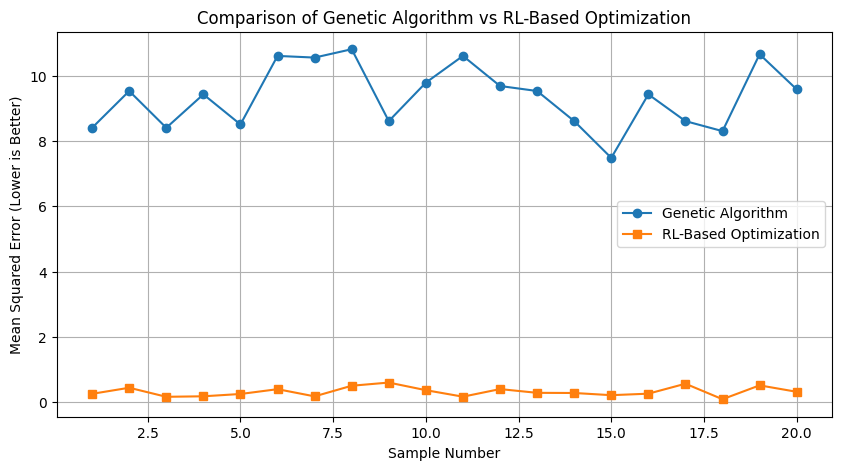

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_comparison["Sample"], df_comparison["Genetic Algorithm MSE"], marker="o", label="Genetic Algorithm")
plt.plot(df_comparison["Sample"], df_comparison["RL-Based Optimization MSE"], marker="s", label="RL-Based Optimization")
plt.xlabel("Sample Number")
plt.ylabel("Mean Squared Error (Lower is Better)")
plt.title("Comparison of Genetic Algorithm vs RL-Based Optimization")
plt.legend()
plt.grid()
plt.show()


In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

mse_genetic = [mean_squared_error(test_features[i], optimized_genetic[i]) for i in range(20)]
mse_rl = [mean_squared_error(test_features[i], rl_optimized[i]) for i in range(20)]

max_actual_value = np.max(test_features)
accuracy_genetic = [100 - (mse / max_actual_value * 100) for mse in mse_genetic]
accuracy_rl = [100 - (mse / max_actual_value * 100) for mse in mse_rl]

df_comparison = pd.DataFrame({
    "Sample": list(range(1, 21)),
    "Genetic Algorithm MSE": mse_genetic,
    "RL-Based Optimization MSE": mse_rl,
    "Genetic Algorithm Accuracy (%)": accuracy_genetic,
    "RL-Based Optimization Accuracy (%)": accuracy_rl
})

df_comparison.to_csv("accuracy_comparison.csv", index=False)
print(" Accuracy comparison saved as accuracy_comparison.csv")

print(df_comparison.head())


 Accuracy comparison saved as accuracy_comparison.csv
   Sample  Genetic Algorithm MSE  RL-Based Optimization MSE  \
0       1               8.410256                   0.248683   
1       2               9.538462                   0.435243   
2       3               8.410256                   0.157472   
3       4               9.435897                   0.172911   
4       5               8.512821                   0.243851   

   Genetic Algorithm Accuracy (%)  RL-Based Optimization Accuracy (%)  
0                       55.735493                           98.691143  
1                       49.797571                           97.709249  
2                       55.735493                           99.171198  
3                       50.337382                           99.089943  
4                       55.195682                           98.716576  


 Overall Genetic Algorithm Accuracy: 50.72%
 Overall RL-Based Optimization Accuracy: 98.34%


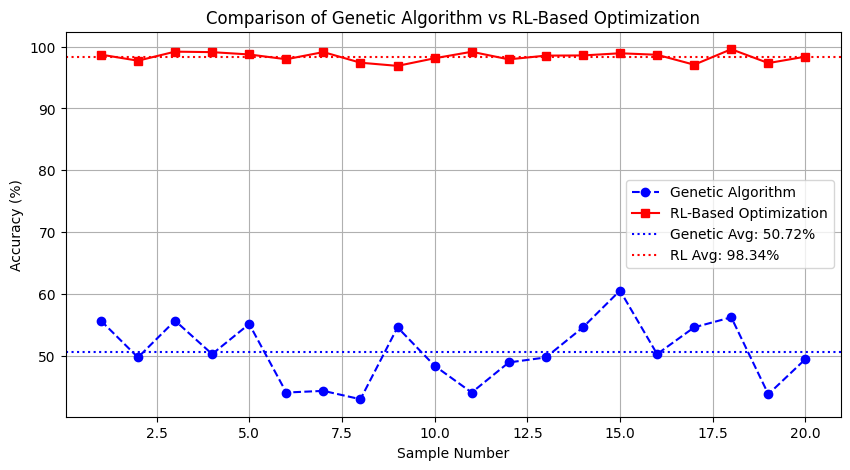

In [15]:

mean_accuracy_genetic = np.mean(accuracy_genetic)
mean_accuracy_rl = np.mean(accuracy_rl)

print(f" Overall Genetic Algorithm Accuracy: {mean_accuracy_genetic:.2f}%")
print(f" Overall RL-Based Optimization Accuracy: {mean_accuracy_rl:.2f}%")


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), accuracy_genetic, label="Genetic Algorithm", marker="o", linestyle="--", color="blue")
plt.plot(range(1, 21), accuracy_rl, label="RL-Based Optimization", marker="s", linestyle="-", color="red")

plt.axhline(y=mean_accuracy_genetic, color='blue', linestyle='dotted', label=f"Genetic Avg: {mean_accuracy_genetic:.2f}%")
plt.axhline(y=mean_accuracy_rl, color='red', linestyle='dotted', label=f"RL Avg: {mean_accuracy_rl:.2f}%")

plt.xlabel("Sample Number")
plt.ylabel("Accuracy (%)")
plt.title("Comparison of Genetic Algorithm vs RL-Based Optimization")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error


mse_genetic = [mean_squared_error(test_features[i], optimized_genetic[i]) for i in range(20)]
mse_rl = [mean_squared_error(test_features[i], rl_optimized[i]) for i in range(20)]

max_actual_value = np.max(test_features)

accuracy_genetic = [100 - (mse / max_actual_value * 100) for mse in mse_genetic]
accuracy_rl = [100 - (mse / max_actual_value * 100) for mse in mse_rl]

df_accuracy = pd.DataFrame({
    "Sample": list(range(1, 21)),
    "Genetic Algorithm Accuracy (%)": accuracy_genetic,
    "RL-Based Optimization Accuracy (%)": accuracy_rl
})


df_accuracy.to_csv("accuracy_comparison.csv", index=False)
print(" Accuracy for 20 samples saved as accuracy_comparison.csv")


print(df_accuracy)


 Accuracy for 20 samples saved as accuracy_comparison.csv
    Sample  Genetic Algorithm Accuracy (%)  RL-Based Optimization Accuracy (%)
0        1                       55.735493                           98.691143
1        2                       49.797571                           97.709249
2        3                       55.735493                           99.171198
3        4                       50.337382                           99.089943
4        5                       55.195682                           98.716576
5        6                       44.129555                           97.940481
6        7                       44.399460                           99.101626
7        8                       43.049933                           97.385142
8        9                       54.655870                           96.872629
9       10                       48.448043                           98.101464
10      11                       44.129555                           99.1